### USE THIS ONE 
16 july<br/>
17-July - take out ones that could not be recovered at necropsy; (need to add ones that fell out during pipeline)<br/>
22-July - THIS IS A GOOD COPY<br/>
* processed == 0, unprocessed == 1, used as mask for graph
* present == 0 for those with data (i.e. all in current data; for graphing neg v pos)
* lesion_barcode_num == 0 and present == 0 means sterile (sterile color)

In [22]:
# %matplotlib inline

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
INPUT_FOLDER = '../data/wrangled/abbr4/merged/'
OUTPUT_FOLDER = '../figs/'
DATE = '2016-07-28'
FORMATS = ['svg','pdf']


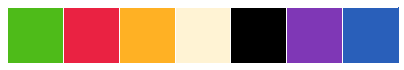

In [3]:
locus_colors = dict( [
    ('ACC','#4EBB19'), # green
    ('EP','#295FBA'), # blue 
    ('LLL','#7F37B6'), # purple
    ('LN','#FFB124'), # yellow
    ('RLL','#EA2242'), # red
    ('cbar','black'),
    ('bad','#FFF3D4')
        
])
%matplotlib inline
locus_palette = sns.palplot(sns.color_palette(locus_colors.values()))


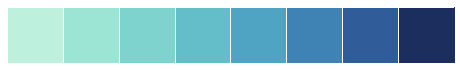

In [4]:
sns.set_style('darkgrid')

def make_palette(as_cmap=False):
    return sns.cubehelix_palette(8, start=2.9, rot=-.28, 
                hue=1.35,gamma=0.6, dark=0.06, light=0.8, as_cmap=as_cmap)

sns.palplot(make_palette())
cmap_1 = make_palette(True)
cmap_1.set_bad(locus_colors['bad'])


In [5]:
def find_files():
    files = np.array([])
    for directory, sub, fnames in os.walk(INPUT_FOLDER):
        for f in fnames:
            if f.split("-")[0]=='merged' and f[-4:]=='.csv': 
                fpath = "%s%s"%(directory, f)
                files = np.append(files, [fpath])
    return files


In [6]:
# cats for pivot table
# excludes cfu, x, y, molecs
INDEXES = ['lesion_tissue_type','lesion_locus','lesion_id','lesion','z','lesion_dissem_type']
COLUMNS = ['barcode_dissem_type','barcode_id','barcode','max_lesion_z']
VALUES = ['percent_molecs']

def create_pivot_table(f):
    testd = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    pivotdf = pd.pivot_table(testd, index=INDEXES, columns=COLUMNS, values=VALUES, fill_value=0)
    # sort axes
    pivotdf.sort_index(level = [ 'lesion_tissue_type','lesion_locus','lesion_id' ], inplace=True )
    pivotdf.columns = pivotdf.columns.droplevel(level=[0,'barcode','max_lesion_z'])
    # get rid of columns no longer needed
    pivotdf.reset_index(['lesion_tissue_type','lesion_id'],inplace=True,drop=True)
    return pivotdf

In [44]:
def plot_heatmap(loc, dis, pivotdf, mask_value, set_title=True, monkey=""):
    
    arr = pivotdf.query('lesion_locus == "%s"'%loc)[dis]
    mask = arr.values==mask_value
    output = []
    

    # actually plot the thing
    f, ax = plt.subplots(1)
    if ((loc=='RLL') and (dis=='contained')):
        cbar_f, cbar_ax = plt.subplots(1)
        ax = sns.heatmap( arr, vmin=0, mask=mask, cmap=cmap_1, cbar=True, cbar_ax=cbar_ax,
                         ax=ax, square=True, linewidths=1 )
        cbar_f.set_size_inches(0.7,5)
#         cbar_yticks = ["%s"%t.get_text() for t in cbar_ax.get_yticklabels()  ]
        cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize='xx-large')
        output.append((cbar_f,cbar_ax,'cbar'))
    else:
        ax = sns.heatmap( arr, vmin=0, mask=mask, cmap=cmap_1, cbar=False,
                         ax=ax, square=True, linewidths=1 )
    
    # axes formatting and such
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    lesion_info = arr.index.values[::-1]
    xticklabels = [t.get_text() for t in ax.get_xticklabels()] 
    yticklabels = np.array(["* %s"%(l[1]) if l[3]=='disseminating' else "%s"%l[1] 
                            for l in lesion_info ])

    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=8)

    ax.set_xticklabels(xticklabels, rotation=90, ha='center', 
                       va='top', fontsize='xx-large')
    ax.set_yticklabels(yticklabels, rotation=0, ha='right',color=locus_colors[loc], 
                       fontsize='xx-large')
    title =  "%s %s (%s barcodes)"%(monkey,loc,dis)
    ax.set_title(title, fontsize='x-large' )
    w = len(xticklabels)*.6*.7
    h = (len(yticklabels)+.1)*.7
    f.set_size_inches(w, h)
    # YAY!
    output.append((f,ax,title))
    return np.array(output)[::-1]

In [53]:
cax.tick_params(axis='y',which='major',length = 8, width = 1, pad=10, direction='out')

In [55]:
all_graphs['17814'][('cbar','cbar')][0].savefig(OUTPUT_FOLDER+"cbar.svg")
all_graphs['17814'][('cbar','cbar')][0].savefig(OUTPUT_FOLDER+"cbar.pdf")

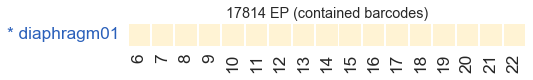

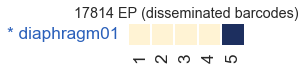

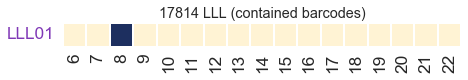

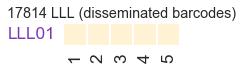

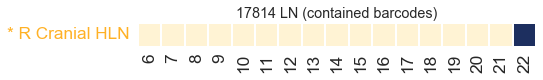

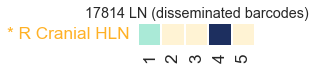

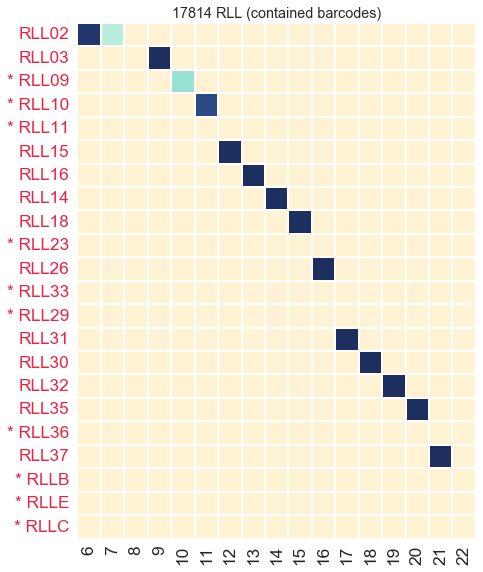

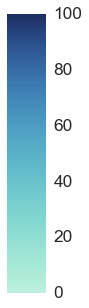

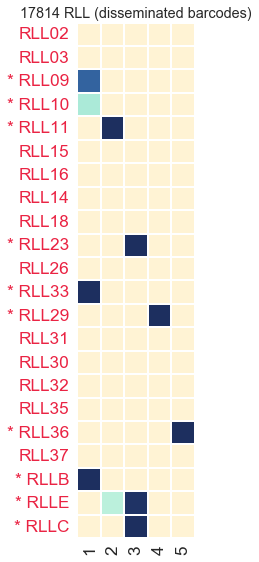

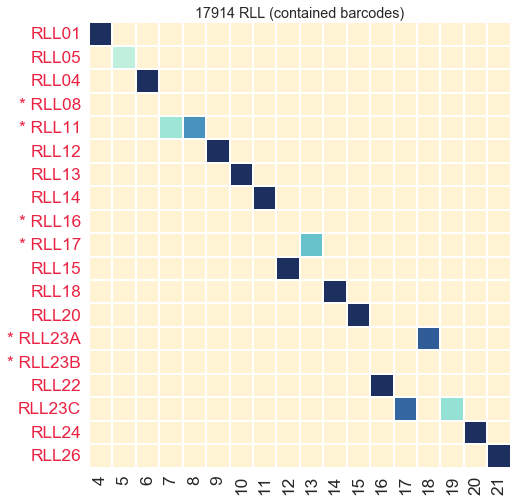

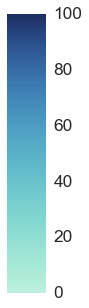

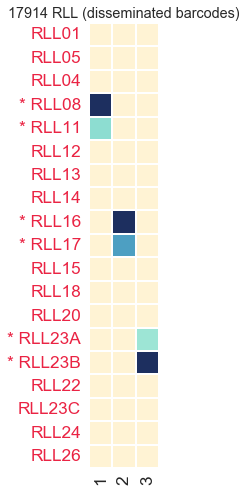

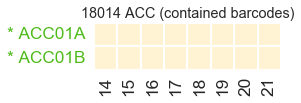

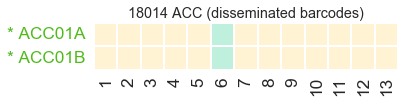

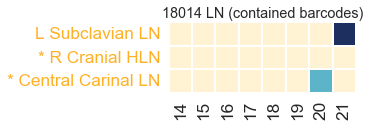

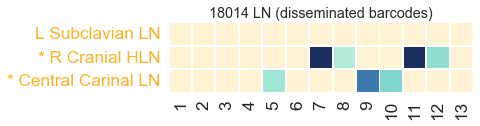

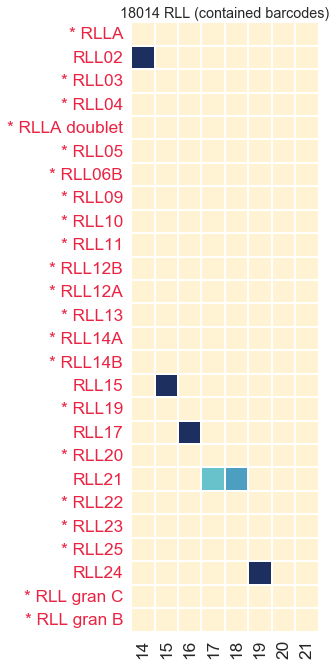

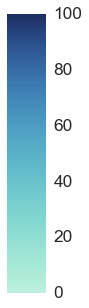

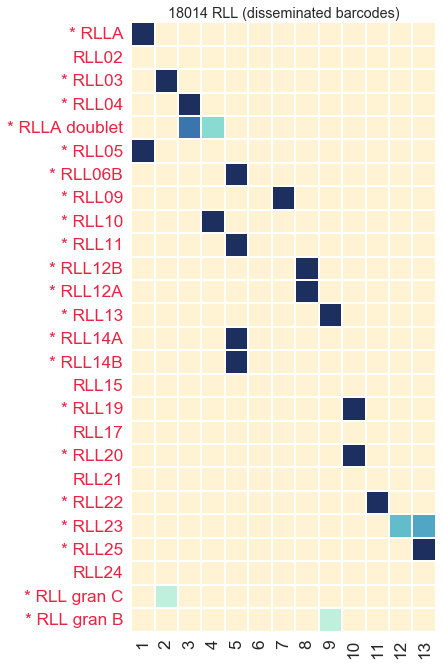

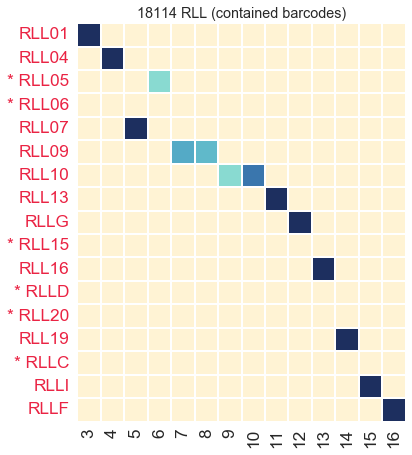

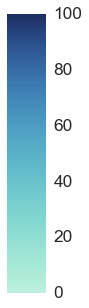

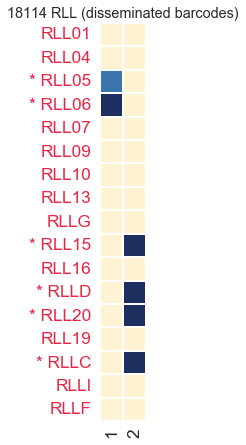

In [45]:
all_graphs = {}
pivoted_dfs = {}
OUTPUT_FOLDER = '../figs/'
mask_value = 0

if not os.path.isdir("../data/pivoted/"): os.mkdir("../data/pivoted/")
    
for f in find_files():
    monkey = f[:-4].split("-")[1]
    pivoted = create_pivot_table(f)
    
    graphs = {}
    loci = np.unique(pivoted.index.get_level_values('lesion_locus'))
    barcode_dissem = pivoted.columns.levels[0]
    for locus in loci:
        for dissem in barcode_dissem:
            output = plot_heatmap(locus,dissem, pivoted, mask_value, monkey=monkey)
            if len(output) > 1:
                graphs[('cbar','cbar')] = output[1]
            graphs[(locus,dissem)]  = output[0]
    all_graphs[monkey]=graphs
    pivoted_dfs[monkey] = pivoted
    pivoted.to_csv("../data/pivoted/pivoted-%s.csv"%monkey)


In [31]:
FORMATS = ['svg','pdf']
def set_axes_visible(save_dir, compact=True, save=False):
    for monkey in all_graphs:
        monkey_dir = "%s%s/"%(save_dir, monkey)
        if not os.path.isdir(monkey_dir): os.mkdir(monkey_dir)
        for fmt in FORMATS:
            if not os.path.isdir(monkey_dir+fmt): os.mkdir(monkey_dir+fmt)
        for key in all_graphs[monkey]:
            loc, dis = key
            f, ax, title = all_graphs[monkey][key]
            if loc!='cbar':
                xvis = False if loc!='LN' and compact==True else True
                yvis = False if dis=='contained' and compact==True else True
            else: 
                xvis = True
                yvis = True
                
            new_title = "" if compact else title

            ax.get_xaxis().set_visible(xvis)
            ax.get_yaxis().set_visible(yvis)
            ax.set_title(new_title)
            
            if save:
                fname = "heatmap-%s-%s-%s-%s"%(monkey, loc, dis, 
                                               'compact' if compact else 'full')
                for fmt in FORMATS:
                
                    f.savefig("%s%s/%s.%s"%(monkey_dir, fmt, fname,fmt), transparent=True)
    return
            
            
            
#                       

In [39]:
for k, (f,ax,g) in all_graphs['18114'].items():
    if k[0]!='cbar':
        ax.get_xaxis().set_visible(True)
        fname = "heatmap-18114-RLL-%s-compact"%(k[1])
        for fmt in FORMATS:
            f.savefig("%scompact/18114/%s/%s.%s"%(OUTPUT_FOLDER, fmt, fname,fmt), transparent=True)

In [32]:
# compacted
path_compact = OUTPUT_FOLDER+"compact/"
if not os.path.isdir(path_compact): os.mkdir(path_compact)
set_axes_visible(path_compact, save=True)

In [33]:
# full
path_full = OUTPUT_FOLDER+"full/"
if not os.path.isdir(path_full): os.mkdir(path_full)
set_axes_visible(path_full,compact=False, save=True)

## TO DO (AI)

  * larger ticklabel fontsize - done
  * color code ticklabels based on locus - done
  * tight_layout?

In [34]:
# ## OPTIONAL ASSIGN MASK VALUE TO 
# # assign mask to dissem, contained subrows per lesion if subrow all neg
# def assign_mask_value(row):
#     # barcode dissem type level == 0
#     for i in range(len(row.index.levels)):
#         level = row.index.levels[0][i]
#         labels = row.index.labels[0]
#         if row.values[labels==i].sum() == 0: 
#             row.loc[(level, slice(None) )] = -1
#     return row
# pivotdf = pivotdf.apply(assign_mask_value, axis=1)

In [35]:
# g_rows = [[],[]]
# g_cols = [[],[]]
# for r in pivotdf.index.get_level_values('lesion_locus'):
#     if not r in g_rows[0]:
#         g_rows[0].append(r)
#         g_rows[1].append(len(pivotdf.loc[r]))
# for c in pivotdf.columns.levels[0]:
#     if not c in g_cols[0]:
#         g_cols[0].append(c)
#         g_cols[1].append(len(pivotdf[c].T))